[Оригинальный notebook](https://www.kaggle.com/code/sharthz23/implicit-lightfm/notebook)

Не все результаты совпадают т. к. используются некоторые модификации в обработке признаков

In [237]:
import os
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.als import AlternatingLeastSquares
from implicit import gpu
from lightfm.data import Dataset
from lightfm import LightFM
import polars as pl

Implicit ALS с GPU:

In [144]:
gpu.HAS_CUDA

True

In [145]:
sns.set_style("darkgrid")

In [146]:
%load_ext autoreload
%autoreload 2

from recs_utils.metrics import compute_metrics, model_cross_validate
from recs_utils.load_data import MTSDataset
from recs_utils.split import TimeRangeSplit
from recs_utils.implicit_model import ImplicitRecommender, LightFMRecommender
from recs_utils.utils import get_direct_and_inv_mapping

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Подготовка данных

In [147]:
data_dir = "data"

In [148]:
df = MTSDataset.load_interactions(os.path.join(data_dir, "interactions.csv"))
df_users = MTSDataset.load_users(os.path.join(data_dir, "users.csv"))
df_items = MTSDataset.load_items(os.path.join(data_dir, "items.csv"))

In [149]:
df_items = MTSDataset.select_genres(df_items, 0.98)

In [150]:
df_items.head()

item_id,title,genres,authors,year
u32,str,str,cat,cat
128115,"""ворон-челобитч…","""зарубежная кла…","""Михаил Салтыко…","""1886"""
210979,"""скрипка ротшил…","""классическая п…","""Антон Чехов""","""1894"""
95632,"""испорченные де…","""зарубежная кла…","""Михаил Салтыко…","""1869"""
247906,"""странный челов…","""литература 19 …","""Михаил Лермонт…","""1831"""
294280,"""господа ташкен…","""зарубежная кла…","""Михаил Салтыко…","""1873"""


In [151]:
users_mapping, users_inv_mapping = get_direct_and_inv_mapping(df, "user_id")
len(users_mapping)

151600

In [152]:
items_mapping, items_inv_mapping = get_direct_and_inv_mapping(df, "item_id")
len(items_mapping)

59599

In [153]:
df_items = df_items.with_columns(pl.col("title").str.strip().str.to_lowercase().alias("title"))

In [154]:
item_titles = {item_info["item_id"]: item_info["title"] for item_info in df_items.select(pl.col("item_id"), pl.col("title")).unique().to_dicts()}

In [155]:
len(item_titles), item_titles[128115]

(59599, 'ворон-челобитчик')

In [156]:
df_items.head()

item_id,title,genres,authors,year
u32,str,str,cat,cat
128115,"""ворон-челобитч…","""зарубежная кла…","""Михаил Салтыко…","""1886"""
210979,"""скрипка ротшил…","""классическая п…","""Антон Чехов""","""1894"""
95632,"""испорченные де…","""зарубежная кла…","""Михаил Салтыко…","""1869"""
247906,"""странный челов…","""литература 19 …","""Михаил Лермонт…","""1831"""
294280,"""господа ташкен…","""зарубежная кла…","""Михаил Салтыко…","""1873"""


In [157]:
title_items = df_items.sort("title").select(
    pl.col("title"),
    pl.col("item_id").implode().over("title"),
    pl.count().over("title")
).unique("title", maintain_order=True)

In [158]:
title_items.head(n=4)

title,item_id,count
str,list[u32],u32
"""# 20 восьмая""",[201623],1
"""# duo""",[72582],1
"""# me too. рома…",[171172],1
"""# партия""",[224512],1


In [159]:
title_items.select(pl.col("count").value_counts(sort=True))

count
struct[2]
"{1,55708}"
"{2,1197}"
"{3,245}"
"{4,71}"
"{5,38}"
"{6,11}"
"{7,8}"
"{8,3}"
"{9,2}"


In [160]:
title_items.filter(pl.col("count") > 1).tail()

title,item_id,count
str,list[u32],u32
"""яма""","[60156, 165785]",2
"""янки из коннек…","[14759, 56530]",2
"""японская диета…","[168986, 74652]",2
"""яр""","[168761, 5371]",2
"""ящик пандоры""","[236465, 158851]",2


In [161]:
df_items.filter(pl.col("title") == "ящик пандоры")

item_id,title,genres,authors,year
u32,str,str,cat,cat
236465,"""ящик пандоры""","""любовно-фантас…","""Филипп Хорват""","""2017"""
158851,"""ящик пандоры""","""мистика,соврем…","""Бернар Вербер""","""2018"""


In [162]:
title_items.filter(pl.col("count") > 1).head()

title,item_id,count
str,list[u32],u32
"""(о переводе)""","[61213, 145263]",2
"""2084""","[177082, 281410]",2
"""451 градус по …","[44681, 162716]",2
"""playboy 02-201…","[114405, 8599]",2
"""playboy 03-201…","[31097, 121747]",2


In [163]:
df_items.filter(pl.col("title") == "451 градус по фаренгейту")

item_id,title,genres,authors,year
u32,str,str,cat,cat
44681,"""451 градус по …","""зарубежная фан…","""Рэй Брэдбери""","""1953"""
162716,"""451 градус по …","""зарубежная фан…","""Рэй Брэдбери""","""1951, 1953, 19…"


In [164]:
df.head(n=3)

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
126706,14433,80,NaN,2018-01-01
127290,140952,58,NaN,2018-01-01
66991,198453,89,NaN,2018-01-01


In [165]:
df.lazy().filter(pl.col("item_id").is_in([44681, 162716])).fill_nan(None).groupby("item_id").agg(
    [
        pl.count("progress"),
        pl.col("rating").min().alias("min_rating"),
        pl.col("rating").mean().alias("mean_rating"),
        pl.col("rating").max().alias("max_rating"),
        pl.col("start_date").min().alias("min_start_date"),
        pl.col("start_date").max().alias("max_start_date")
    ]
).collect()

item_id,progress,min_rating,mean_rating,max_rating,min_start_date,max_start_date
u32,u32,f32,f32,f32,date,date
44681,353,1.0,4.56,5.0,2018-01-24,2019-12-20
162716,59,4.0,4.8,5.0,2018-01-25,2019-12-30


In [166]:
last_date = df.select(pl.col("start_date").max())[0, 0]

In [167]:
folds = 7
start_date = last_date - datetime.timedelta(days=folds)
start_date, last_date

(datetime.date(2019, 12, 24), datetime.date(2019, 12, 31))

In [168]:
cv = TimeRangeSplit(start_date=start_date, interval=datetime.timedelta(days=1), folds=folds)

cv.max_n_splits, cv.get_n_splits(df, datetime_column='start_date')

(7, 7)

In [169]:
cv.date_range[1:]

date_col
date
2019-12-25
2019-12-26
2019-12-27
2019-12-28
2019-12-29
2019-12-30
2019-12-31


In [170]:
folds_with_stats = list(cv.split(
    df, 
    user_column='user_id',
    item_column='item_id',
    datetime_column='start_date',
    fold_stats=True
)
)

folds_info_with_stats = pl.DataFrame([info for _, _, info in folds_with_stats])

In [171]:
folds_info_with_stats

Start date,End date,Train,New users,New users interactions,New items,New items interactions,Known interactions,Test
date,date,i64,i64,i64,i64,i64,i64,i64
2019-12-24,2019-12-25,1515946,3,3,0,0,0,2045
2019-12-25,2019-12-26,1517994,1,1,0,0,0,2141
2019-12-26,2019-12-27,1520136,0,0,0,0,0,2177
2019-12-27,2019-12-28,1522313,0,0,0,0,0,2110
2019-12-28,2019-12-29,1524423,2,4,0,0,0,2205
2019-12-29,2019-12-30,1526632,4,4,0,0,0,2118
2019-12-30,2019-12-31,1528754,1,1,0,0,0,2168


In [172]:
top_N = 10

# Implicit

In [173]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
test = df.join(test_idx, on=["user_id", "item_id"], how="inner")
train.shape, test.shape

((1515946, 5), (2045, 5))

In [174]:
cosine_model = ImplicitRecommender(CosineRecommender(K=10), users_mapping, items_mapping, items_inv_mapping)

In [175]:
cosine_model.fit(train)

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010876655578613281 seconds
  warnings.warn(


  0%|          | 0/59599 [00:00<?, ?it/s]

In [176]:
user_id = test.select(pl.col("user_id"))[0, 0]
print(f'Рекомендации для пользователя {user_id}')

Рекомендации для пользователя 139942


In [177]:
pred_recs = cosine_model.recommend([user_id], n=top_N)

In [178]:
pred_recs

user_id,item_id,rank
u32,u32,u32
139942,193358,1
139942,125586,2
139942,203882,3
139942,90986,4
139942,146180,5
139942,264849,6
139942,238155,7
139942,7094,8
139942,240226,9


In [179]:
test.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
139942,26270,58,NaN,2019-12-24
136607,82392,39,NaN,2019-12-24
142287,84446,79,NaN,2019-12-24
114933,319155,9,NaN,2019-12-24
32926,120339,73,NaN,2019-12-24


In [180]:
pred_recs = cosine_model.recommend(test.select(pl.col("user_id").unique()).to_series(), n=top_N)

In [181]:
pred_recs.head(top_N + 3)

user_id,item_id,rank
u32,u32,u32
27,205779,1
27,270698,2
27,300693,3
27,44437,4
27,128993,5
27,251031,6
27,261532,7
27,305853,8
27,57696,9


In [182]:
pred_recs.filter(pl.col("user_id") == 139942).head(top_N + 3)

user_id,item_id,rank
u32,u32,u32
139942,193358,1
139942,125586,2
139942,203882,3
139942,90986,4
139942,146180,5
139942,264849,6
139942,238155,7
139942,7094,8
139942,240226,9


In [183]:
test.head()

user_id,item_id,progress,rating,start_date
u32,u32,u8,f32,date
139942,26270,58,NaN,2019-12-24
136607,82392,39,NaN,2019-12-24
142287,84446,79,NaN,2019-12-24
114933,319155,9,NaN,2019-12-24
32926,120339,73,NaN,2019-12-24


In [184]:
metrics = compute_metrics(test, pred_recs, top_N)

In [185]:
metrics

name,value
str,f64
"""prec@1""",0.011628
"""recall@1""",0.011628
"""prec@2""",0.010098
"""recall@2""",0.010098
"""prec@3""",0.00918
"""recall@3""",0.00918
"""prec@4""",0.007956
"""recall@4""",0.007956
"""prec@5""",0.007222


In [186]:
def create_cosine_model():
    return ImplicitRecommender(CosineRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)


def create_bm25():
    return ImplicitRecommender(BM25Recommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_tfidf():
    return ImplicitRecommender(TFIDFRecommender(K=top_N), users_mapping, items_mapping, items_inv_mapping)

def create_alsm():
    return ImplicitRecommender(AlternatingLeastSquares(factors=32, iterations=10), users_mapping, items_mapping, items_inv_mapping)

In [187]:
cv_res_per_model = []
models = {}

In [188]:
for factory in (create_cosine_model, create_bm25, create_tfidf, create_alsm):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model.to_pandas())
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010511398315429688 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.0089569091796875 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.012376785278320312 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01205301284790039 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/impl

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01009678840637207 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01040196418762207 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01168966293334961 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011110305786132812 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/impl

  0%|          | 0/7 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009714365005493164 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011556625366210938 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011826515197753906 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010090351104736328 seconds
  warnings.warn(
/home/alex/miniconda3/envs/recsys/lib/python3.10/site-packages/i

  0%|          | 0/7 [00:00<?, ?it/s]

In [189]:
cross_valid_res = pd.concat(cv_res_per_model)
cv_res_per_model.clear()

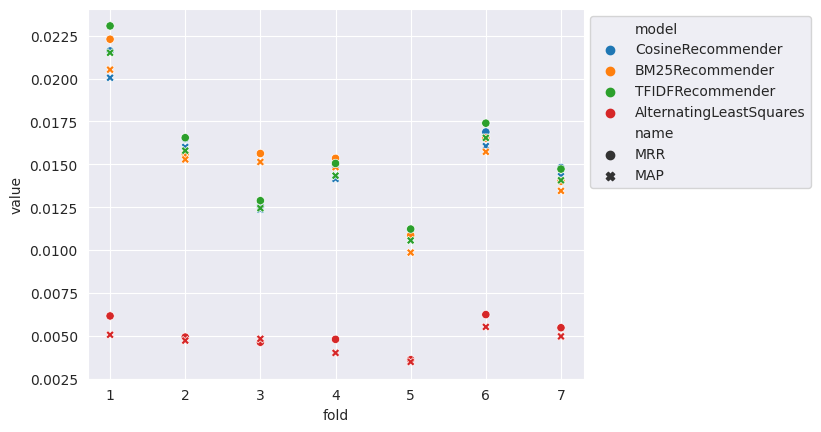

In [190]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["name"].isin(["MAP", "MRR"])], x="fold", y="value", style="name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [191]:
cross_valid_res.pivot(index=["fold", "model"], columns=["name"], values=["value"]).droplevel(level=0, axis="columns").groupby("model").agg(
    {
    "MRR": ['mean', 'std', 'min', 'max'],
    'MAP': ['mean', 'std', 'min', 'max'],
    f'recall@{top_N}': ['mean', 'std', 'min', 'max'],
    }
)

name                          MRR                                     MAP   
                             mean       std       min       max      mean   
model                                                                       
AlternatingLeastSquares  0.005118  0.000925  0.003605  0.006239  0.004655  \
BM25Recommender          0.015759  0.003429  0.010862  0.022296  0.014975   
CosineRecommender        0.015503  0.003368  0.011206  0.021611  0.014784   
TFIDFRecommender         0.015844  0.003811  0.011226  0.023071  0.015038   

name                                                  recall@10             
                              std       min       max      mean       std   
model                                                                       
AlternatingLeastSquares  0.000690  0.003479  0.005521  0.001401  0.000171  \
BM25Recommender          0.003163  0.009854  0.020521  0.003588  0.000606   
CosineRecommender        0.003035  0.010556  0.020050  0.003562  0.000772   
TFIDFRecommender         0.003484  0.010563  0.021505  0.003622  0.000650   

name                                         
                              min       max  
model                                        
AlternatingLeastSquares  0.001285  0.001775  
BM25Recommender          0.003078  0.004774  
CosineRecommender        0.002873  0.004896  
TFIDFRecommender         0.002998  0.004712

In [192]:
models.keys()

dict_keys(['CosineRecommender', 'BM25Recommender', 'TFIDFRecommender', 'AlternatingLeastSquares'])

In [193]:
similiar_items = models["TFIDFRecommender"].similiar_items([60193], top_N)

In [194]:
similiar_items = similiar_items.with_columns(
    pl.col("item_id").apply(item_titles.get).alias("orig_titles"),
    pl.col("similiar_item_id").apply(item_titles.get).alias("sim_titles")
    )

In [195]:
similiar_items

item_id,similiar_item_id,score,orig_titles,sim_titles
u32,u32,f32,str,str
60193,60193,1.0,"""мастер и марга…","""мастер и марга…"
60193,252228,0.085901,"""мастер и марга…","""мастер и марга…"
60193,283431,0.057461,"""мастер и марга…","""мастер и марга…"
60193,106146,0.038287,"""мастер и марга…","""без имени"""
60193,129959,0.034565,"""мастер и марга…","""белая гвардия.…"
60193,229856,0.033712,"""мастер и марга…","""булгаков и «ма…"
60193,284757,0.033223,"""мастер и марга…","""стори 11-2015"""
60193,214968,0.03252,"""мастер и марга…","""драгоценная пл…"
60193,303726,0.031764,"""мастер и марга…","""ничего не возь…"


# LightFM

In [196]:
dataset = Dataset()

In [197]:
dataset.fit(df.select(pl.col("user_id")).unique().to_series(), df.select(pl.col("item_id")).unique().to_series())

In [198]:
lfm_df_users = df_users.clone()
lfm_df_items = df_items.clone()

In [199]:
lfm_df_users = lfm_df_users.with_columns(
    pl.col("age").cast(str).fill_null("age_unknown").cast(pl.Categorical).alias("age"),
    pl.col("sex").cast(str).fill_null("sex_unknown").cast(pl.Categorical).alias("sex")
)

In [200]:
lfm_df_users.select(pl.col("sex").unique())

sex
cat
"""sex_unknown"""
"""0"""
"""1"""


In [201]:
lfm_df_users.select(pl.col("age").unique())

age
cat
"""45_54"""
"""18_24"""
"""65_inf"""
"""35_44"""
"""55_64"""
"""25_34"""
"""age_unknown"""


In [202]:
age_features = lfm_df_users.select(pl.col("age").unique()).to_series().to_list()
sex_features = lfm_df_users.select(pl.col("sex").unique()).to_series().to_list()

In [203]:
users_features = age_features + sex_features
users_features

['45_54',
 '18_24',
 '65_inf',
 '35_44',
 '55_64',
 '25_34',
 'age_unknown',
 'sex_unknown',
 '0',
 '1']

In [204]:
dataset.fit_partial(user_features=users_features)

In [205]:
genres = lfm_df_items.select(pl.col("genres").cast(str).str.split(',').explode().unique()).to_series().to_list()
len(genres)

236

In [206]:
dataset.fit_partial(item_features=genres)

In [207]:
num_users, num_items = dataset.interactions_shape()
num_users, num_items

(151600, 59599)

In [208]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'user_features_mapping': lightfm_mapping[1],
    'items_mapping': lightfm_mapping[2],
    'item_features_mapping': lightfm_mapping[3],
}
print('users_mapping len - ', len(lightfm_mapping['users_mapping']))
print('user_features_mapping len - ', len(lightfm_mapping['user_features_mapping']))
print('items_mapping len - ', len(lightfm_mapping['items_mapping']))
print('Users item_features_mapping len - ', len(lightfm_mapping['item_features_mapping']))

users_mapping len -  151600
user_features_mapping len -  151610
items_mapping len -  59599
Users item_features_mapping len -  59835


In [209]:
lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

In [210]:
num_user_features = dataset.user_features_shape()
num_show_features = dataset.item_features_shape()
print('Num user features: {} -> {}\nnum item features: {} -> {}.'.format(
    num_user_features[1] - num_users, num_user_features[1], 
    num_show_features[1] - num_items, num_show_features[1]))

Num user features: 10 -> 151610
num item features: 236 -> 59835.


In [211]:
train_idx, test_idx, info = folds_with_stats[0]

train = df.join(train_idx, on=["user_id", "item_id"], how="inner")
test = df.join(test_idx, on=["user_id", "item_id"], how="inner")

In [212]:
train_mat, train_mat_weights = dataset.build_interactions(train.select(
    pl.col("user_id"),
    pl.col("item_id")
).to_numpy()
)
train_mat

<151600x59599 sparse matrix of type '<class 'numpy.int32'>'
	with 1515946 stored elements in COOrdinate format>

In [213]:
train_mat_weights

<151600x59599 sparse matrix of type '<class 'numpy.float32'>'
	with 1515946 stored elements in COOrdinate format>

In [214]:
lfm_df_users = lfm_df_users.with_columns(
    pl.concat_list(pl.col("age").cast(str), pl.col("sex").cast(str)).alias("features")
)

In [215]:
lfm_df_users.head()

user_id,age,sex,features
u32,cat,cat,list[str]
1,"""45_54""","""sex_unknown""","[""45_54"", ""sex_unknown""]"
2,"""18_24""","""0""","[""18_24"", ""0""]"
3,"""65_inf""","""0""","[""65_inf"", ""0""]"
4,"""18_24""","""0""","[""18_24"", ""0""]"
5,"""35_44""","""0""","[""35_44"", ""0""]"


In [216]:
def to_light_fm_feature(row_info: dict, entity_key: str):
    return (row_info[entity_key], row_info["features"])

In [217]:
known_users_mask = lfm_df_users.select(pl.col("user_id").is_in(df.select(pl.col("user_id").unique()).to_series())).to_series()

train_user_features = dataset.build_user_features(
    map(lambda x: to_light_fm_feature(x, "user_id"), lfm_df_users.filter(known_users_mask).select(pl.col("user_id"), pl.col('features')).to_dicts())
)

train_user_features

<151600x151610 sparse matrix of type '<class 'numpy.float32'>'
	with 422954 stored elements in Compressed Sparse Row format>

In [218]:
lfm_df_items = lfm_df_items.with_columns(
    pl.col("genres").cast(str).str.split(",").alias("features")
)

In [219]:
lfm_df_items.head()

item_id,title,genres,authors,year,features
u32,str,str,cat,cat,list[str]
128115,"""ворон-челобитч…","""зарубежная кла…","""Михаил Салтыко…","""1886""","[""зарубежная классика"", ""зарубежные детские книги"", … ""сказки""]"
210979,"""скрипка ротшил…","""классическая п…","""Антон Чехов""","""1894""","[""классическая проза"", ""литература 19 века"", ""русская классика""]"
95632,"""испорченные де…","""зарубежная кла…","""Михаил Салтыко…","""1869""","[""зарубежная классика"", ""классическая проза"", … ""русская классика""]"
247906,"""странный челов…","""литература 19 …","""Михаил Лермонт…","""1831""","[""литература 19 века"", ""пьесы и драматургия""]"
294280,"""господа ташкен…","""зарубежная кла…","""Михаил Салтыко…","""1873""","[""зарубежная классика"", ""классическая проза"", … ""русская классика""]"


In [220]:
lfm_df_items.select(
    pl.col("features").apply(len).value_counts(sort=True)
)

features
struct[2]
"{1,21591}"
"{2,21037}"
"{3,11909}"
"{4,3707}"
"{5,846}"
"{6,278}"
"{7,107}"
"{8,61}"
"{9,27}"


In [221]:
known_items_mask = lfm_df_items.select(pl.col("item_id").is_in(df.select("item_id").unique().to_series())).to_series()

train_items_features = dataset.build_item_features(
        map(lambda x: to_light_fm_feature(x, "item_id"), lfm_df_items.filter(known_items_mask).select(
    pl.col("item_id"),
    pl.col("features")
        ).to_dicts())
)
train_items_features

<59599x59835 sparse matrix of type '<class 'numpy.float32'>'
	with 181602 stored elements in Compressed Sparse Row format>

In [222]:
lfm_model = LightFM(no_components=64, learning_rate=0.05, loss='warp', max_sampled=5, random_state=23)

In [223]:
num_epochs = 5

for _ in trange(num_epochs):
    lfm_model.fit_partial(
        train_mat, 
        user_features=train_user_features,
        item_features=train_items_features,
        num_threads=4
    )

  0%|          | 0/5 [00:00<?, ?it/s]

In [224]:
user_id = test.filter(pl.col("user_id") == 139942).select(pl.col("user_id"))[0, 0]
row_id = lightfm_mapping['users_mapping'][user_id]
print(f'Рекомендации для пользователя {user_id}, номер строки - {row_id}')

Рекомендации для пользователя 139942, номер строки - 119847


In [225]:
all_cols = list(lightfm_mapping['items_mapping'].values())
len(all_cols)

59599

In [226]:
pred = lfm_model.predict(row_id, all_cols, user_features=train_user_features, item_features=train_items_features)
pred, pred.shape

(array([-102.399666, -102.27788 , -100.914604, ..., -102.00917 ,
        -103.496284, -102.586174], dtype=float32),
 (59599,))

In [227]:
top_cols = np.argpartition(pred, -np.arange(top_N))[-top_N:][::-1]
top_cols

array([43123, 38371, 53841,  4872,  7267, 13883, 43849, 55704, 35407,
       13245])

In [228]:
pred[top_cols]

array([-98.128944, -98.70728 , -98.781395, -98.78466 , -98.78621 ,
       -98.82544 , -98.8553  , -98.86375 , -98.86632 , -98.92416 ],
      dtype=float32)

In [229]:
pred.max()

-98.128944

In [230]:
recs = pl.DataFrame(
    {"col_id": top_cols,
     "item_id": list(map(lightfm_mapping['items_inv_mapping'].get, top_cols))
    },
    schema={"col_id": test.schema["item_id"], "item_id": test.schema["item_id"]}
)
recs = recs.with_columns(pl.col("item_id").apply(item_titles.get).alias("title"))
recs

col_id,item_id,title
u32,u32,str
43123,99357,"""сила подсознан…"
38371,281005,"""богатый папа, …"
53841,90519,"""думай медленно…"
4872,310952,"""вы ничего не з…"
7267,89152,"""50 правил умно…"
13883,211217,"""ни сы. восточн…"
43849,264997,"""после"""
55704,24551,"""магическая убо…"
35407,159580,"""пятьдесят отте…"


In [231]:
def create_lightfm():
    return LightFMRecommender(
        LightFM(
            no_components=64, 
            learning_rate=0.05, 
            loss='warp', 
            max_sampled=5, 
            random_state=23),
             num_epoch=15,
             num_threads=5)

In [232]:
cv_res_per_model.clear()

In [234]:
for factory in (create_lightfm, ):
    cross_valid_res_model, model = model_cross_validate(
        df, 
        user_features=df_users, 
        item_features=df_items, 
        folds=folds_with_stats, 
        model_factory=factory, 
        n=top_N)
    models[model.model_name()] = model
    cv_res_per_model.append(cross_valid_res_model.to_pandas())
    del cross_valid_res_model

  0%|          | 0/7 [00:00<?, ?it/s]

In [235]:
cross_valid_res = pd.concat([cross_valid_res] + cv_res_per_model)
cv_res_per_model.clear()

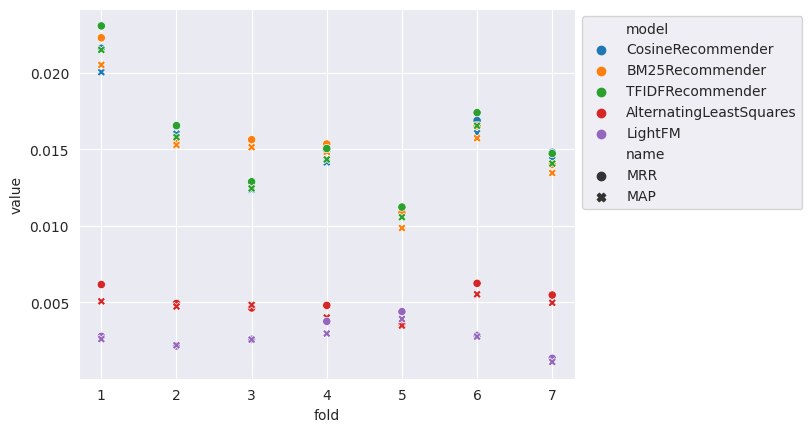

In [236]:
ax = sns.scatterplot(cross_valid_res[cross_valid_res["name"].isin(["MAP", "MRR"])], x="fold", y="value", style="name", hue="model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))